## Tracking de Icebergs

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape, mapping
import json
import geemap,ee
import folium
ee.Authenticate()
ee.Initialize()

- Primero definimos nuestro icebergs de interes

Para este proceso, directamente en Google engine seleccionamos manualmente el icebreg de interes. Se puede ver la seleccion del iceberg en el siguiente link: https://code.earthengine.google.com/05e082f6fec74c5efd69e7b96c366904

In [9]:
df = pd.read_csv("Icebergs\iceberg_0003_2020-06-01.csv")
df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))

gdf = gpd.GeoDataFrame(df, geometry='geometry').set_crs('epsg:4326', inplace=True)

<Axes: >

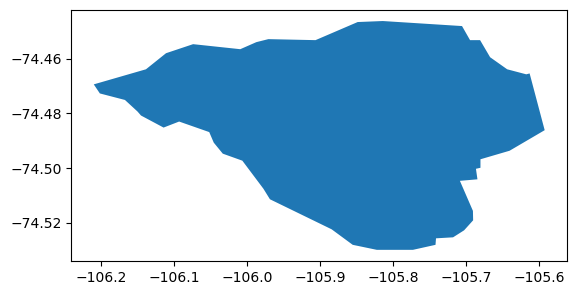

In [10]:
gdf["geometry"].plot()

- Luego, haciendo comparativas de similitud, localizamos el mismo iceberg en una imagen posterior. (Con un cierto margen de error)

#### 1. Pasamos nuestro archivo local a una Feature collection

In [11]:
gdf.columns = [col.replace('.', '_') for col in gdf.columns]

# Verificamos que todas las columnas son strings
for col in gdf.columns:
    if col != 'geometry':
        gdf[col] = gdf[col].astype(str)

# Convertimos el GeoDataFrame a una lista de Features
features = []
for _, row in gdf.iterrows():
    geom = ee.Geometry(mapping(row['geometry']))
    feature = ee.Feature(geom, row.drop('geometry').to_dict())
    features.append(feature)


iceberg = ee.FeatureCollection(features)


#### 2. Una vez obtenida la feature collection del iceberg, obtenemos las imagenes satelitales de esté.

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD

In [12]:
#Las imagenes se tomaran cada 2 dias por ende partimos desde el 1 al 3
fecha_inicio = '2020-06-01'
fecha_fin = '2020-06-03'

In [13]:
#Se obtienen las imagenes del satelite iniciales
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate(fecha_inicio, fecha_fin)\
.filterBounds(iceberg)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean().clip(iceberg) 

#### 3. Planteamos una forma de identificar el iceberg. Esta forma requiere calcular cómo varía la distancia desde el centroide hacia los bordes del iceberg. Para ello:

- Definimos una capa de cobertura del iceberg, la cual vale 1 siempre que se abarca el iceberg.

In [14]:
cover = img.select('HH').clip(iceberg).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())

- Definimos una Imagen que vale 1 en el centroide del Iceberg.

In [15]:
centroid = iceberg.geometry().centroid(10).getInfo()['coordinates']

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1)

- Calculamos el costo acumulativo para recorrer la imagen desde el centroide del iceberg hasta los bordes del iceberg.

In [16]:
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(iceberg)

result = cumulativeCost.reduceRegion(ee.Reducer.toList(), iceberg, scale=200, maxPixels=1e20)
A = result.getInfo()['cumulative_cost'] 

- Calculamos un histograma de la distribucion de las distancias centroide-borde

Text(0, 0.5, 'N')

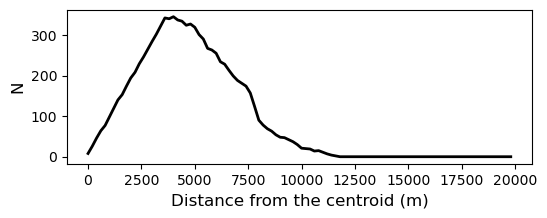

In [17]:
hist1 = {}

scale = 200
max_pix = 20000

fig = plt.subplots(figsize = (6, 2), dpi = 100)
hist1['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])

plt.plot(hist1['reference'][1][:-1], hist1['reference'][0], color = "k", linewidth = 2)
plt.xlabel("Distance from the centroid (m)", fontsize = 12)
plt.ylabel("N", fontsize = 12)

- Obtenemos el area real del iceberg

In [18]:
#Area en metros cuadrados
area0 = iceberg.geometry().area(10).getInfo()
print(area0)

99911989.96066779


Se puede visualizar el iceberg para corroborar que se esteen calculando las medidas en el poligono adecuado.

In [19]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
visParams1 = {"bands": ['HH'], "min": -30, "max": 0}
Map.addLayer(img, visParams1, 'S1')
Map

Map(center=[-74.48329954733886, -105.85766312550345], controls=(WidgetControl(options=['position', 'transparen…

#### 4. Ahora queremos Trackear nuestro iceberg en un lapso de tiempo usando lo anterior.

En cada iteración segmentaremos la zona objetivo usando snic eh identificaremos el iceberg de estudio usando lo anterior.

In [25]:
ice_area = {}
ice_centroid = {}
mapid_seg = {}
mapid_target = {}

center = centroid

buf_dist = 20000 # distancia desde el centroide para buscar icebergs

#se instancia el mapa del cual se hara el trackeo
map1 = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

Dias de estudio: Los dias de estudio son cruciales para el funcionamiento del codigo, si bien queremos trackear el iceberg por 1 año o mas, mientras mas dias pasan de estudio, mayor es la probabilidad de que se pierda nuestro iceberg. Para arreglar este problema ejecutamos el codigo en tandas de 3 o 6 meses dependiendo del iceberg. Este codigo toma un poco de tiempo asi que para hacer una demostracion, se trackeara el iceberg por 10 iteraciones.

In [20]:
# Cuantos dias queremos estudiar
day_range = range(0, 10)

Calculo Area de cada iceberg

In [21]:
#decidir si mantener o no el parametro maxError=10
def addArea(feature):
    return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)})

In [22]:
#En este dataframe se guardara informacion necesaria para hacer el estudio
df_iceberg = pd.DataFrame(columns=['fecha', 'similaridad', 'area', 'centroide', 'poligono'])

La siguiente celda se encarga del trackeo del iceberg.

2020-06-01 ============================================
Feature 0 >>> area: 103.73 km^2, centroid: [-105.865, -74.484], similarity: 0.932
2020-06-03 ============================================
Feature 0 >>> area: 98.7 km^2, centroid: [-105.863, -74.478], similarity: 0.981
2020-06-05 ============================================
Feature 0 >>> area: 97.75 km^2, centroid: [-105.917, -74.45], similarity: 0.786
No hay imagenes para la fecha: 2020-06-07
Se aumento la distancia de busqueda a 40000
2020-06-09 ============================================
Feature 0 >>> area: 96.4 km^2, centroid: [-106.124, -74.35], similarity: 0.929
2020-06-11 ============================================
Feature 0 >>> area: 89.3 km^2, centroid: [-106.164, -74.372], similarity: 0.864
2020-06-13 ============================================
Feature 0 >>> area: 98.88 km^2, centroid: [-106.078, -74.389], similarity: 0.932
2020-06-15 ============================================
Feature 0 >>> area: 98.7 km^2, centroid:

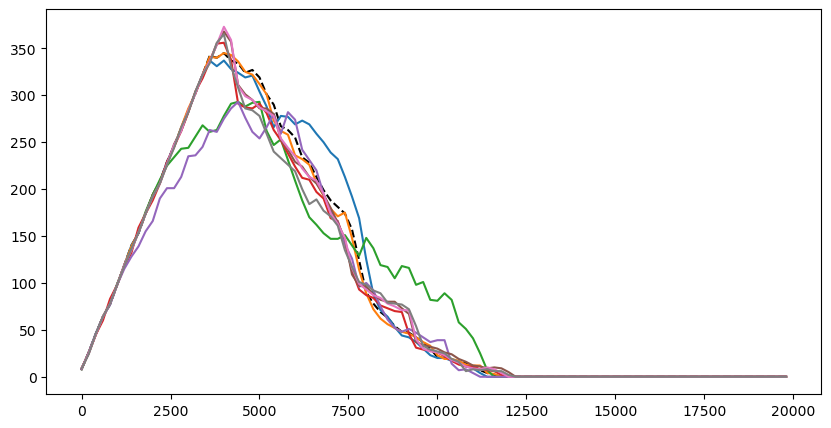

In [27]:
vectorscale = 40

#este plot ayudara a visualizar la similitud de los histogramas
fig = plt.subplots(figsize = (10, 5))
plt.plot(hist1['reference'][1][:-1], hist1['reference'][0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(fecha_inicio, "%Y-%m-%d").month
    band = ["HH", "angle"]
    
    #Circulo de busqueda de radio buf_dist
    aoi = ee.Geometry.Point(center).buffer(buf_dist)

    # Utilizamos las imagenes HH de Sentinel-1
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(fecha_inicio, fecha_fin)\
    .filterBounds(aoi)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

    #Si hay imagenes se ejecuta la busqueda
    if S1A.size().getInfo() > 0:

        #Se clipea para buscar en el circulo
        imageA = S1A.select(band).mean().clip(aoi) 

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(80);

        # Kernel Gaussiano para suavizar la imagen 
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        
        # segmentamos la imagen con SNIC
        # size = 20, compactness= 5, connectivity= 8, neighborhoodSize = 256
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')       

        # dividimos los valores HH por los valores de la banda angle para mejorar el contraste entre los icebergs y el mar abierto o el hielo circundante.
        ratio = snic.select("HH").divide(snic.select("angle"))
        # mantenemos solo los valores mayores que -0.2 (icebergs)
        icebergs = ratio.gt(-0.2).selfMask()     
        
        # convertimos los iceberg raster a vectores
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        # permitimos un margen de error del 20% en el area de los icebergs respecto al iceberg objetivo
        area_max = area0 * 1.2
        area_min = area0 * 0.8
        # obtenemos el area y el centroide de los icebergs
        areaAdded = vectors.map(addArea)
        # filtramos los icebergs que tienen un area entre el 80% y el 120% del area objetivo
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(fecha_inicio + " ============================================")
        threshold = 0.7 #threshold de similitud para considerar un iceberg similar
        find = False
        candidates = []
        
        #Este for funciona siempre y cuando haya al menos 1 figura
        for k in range(0, num): 
            
            #se extraen los features necesarios 
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1)
            covers = snic.select('HH').multiply(0).add(1)
            
            #Costos para el histograma
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            #Comparacion de histogramas
            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix]) 
            
            diff = abs(hist1['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist1['reference'][0])          
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            #Si la similitud sobrepasa el threshold, se guardara el candidato
            if similarity >= threshold: 
                threshold = similarity # al actualizar el threshold aca se asegura que el siguiente candidato tiene que ser mejor que el anterior
                find = True
                candidates.append((fecha_inicio, similarity, area, centroid, polygon, sources, covers, B))

    # caso en el que no encuentra imagenes
    else:
        print(f'No hay imagenes para la fecha: {fecha_inicio}')
        find = False
    
    #si encontro un candidato se guardan las variables necesarias en el dataframe
    if find == True:

        fecha_inicio = candidates[-1][0]
        similarity = candidates[-1][1]
        area = candidates[-1][2]
        centroid = candidates[-1][3]
        polygon = candidates[-1][4]

        B = candidates[-1][7]
        df_iceberg.loc[len(df_iceberg.index)] = [fecha_inicio, similarity, area, centroid, polygon]

        ice_area[fecha_inicio] = area
        ice_centroid[fecha_inicio] = centroid
        hist1[fecha_inicio] = B 
        #histograma para comparar
        plt.plot(B[1][:-1], B[0], label = fecha_inicio + "_" + str(k))
                   
        #se actualiza el nuevo centro de busqueda y se devuelve la distancia de busqueda
        #al valor inicial en caso de haber sido aumentada
        center = centroid
        buf_dist = 20000
    
    # en caso de no haber encontrado un iceberg, se aumenta la distancia de busqueda para el siguiente set de imagenes
    else:
        buf_dist += 20000
        if buf_dist >= 40000:
            print(f'Se aumento la distancia de busqueda a {buf_dist}')
  
    # en caso de que el iceberg se haya alejado tanto que ya no sea razonable la busqueda
    if (buf_dist > 260000): 
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, fecha_inicio))
        break

    # finalmente se actualizan las fechas para la busqueda en los siguientes 2 dias
    fecha_inicio = fecha_fin
    fecha_fin = (dt.datetime.strptime(fecha_fin, "%Y-%m-%d") + dt.timedelta(days=2)).strftime("%Y-%m-%d")

In [29]:
df_iceberg

,fecha,similaridad,area,centroide,poligono
0,2020-06-01,0.932003,1.037304e+08,"[-105.86525521394688, -74.48449116122524]","ee.FeatureCollection({\n ""functionInvocationV..."
1,2020-06-03,0.981319,9.870384e+07,"[-105.86334972554924, -74.47764400226751]","ee.FeatureCollection({\n ""functionInvocationV..."
2,2020-06-05,0.786187,9.774550e+07,"[-105.91744769199555, -74.45022949058462]","ee.FeatureCollection({\n ""functionInvocationV..."
3,2020-06-09,0.929227,9.639895e+07,"[-106.12422360557987, -74.34985659867654]","ee.FeatureCollection({\n ""functionInvocationV..."
4,2020-06-11,0.863898,8.929794e+07,"[-106.1639121063222, -74.37201709532167]","ee.FeatureCollection({\n ""functionInvocationV..."
5,2020-06-13,0.932216,9.887900e+07,"[-106.07841232186726, -74.38947607962689]","ee.FeatureCollection({\n ""functionInvocationV..."
6,2020-06-15,0.936059,9.870263e+07,"[-106.06671642133074, -74.39021344895245]","ee.FeatureCollection({\n ""functionInvocationV..."
7,2020-06-17,0.906277,9.567103e+07,"[-106.14460401232998, -74.37959027958881]","ee.FeatureCollection({\n ""functionInvocationV..."


La ruta del archivo de modificaria dependiendo del trackeo realizado, ahora se muestra con 'ejemplo.csv'. Los csv necesarios para el estudio ya deberian estar guardados.

In [28]:
ruta_archivo = 'ejemplo.csv' 
df_iceberg.to_csv(ruta_archivo, index=False, sep='&')

El siguiente mapa interactivo muestra las 7 primeras fechas del iceberg. (las geomedianas pueden perturbar un poco las imagenes)

In [37]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)

polygon_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style = {'color': 'blue', 'pointSize': 5}
for i, row in df_iceberg.iterrows():
    fecha_inicio = row['fecha']
    fecha_fin = (dt.datetime.strptime(fecha_inicio, "%Y-%m-%d") + dt.timedelta(days=2)).strftime("%Y-%m-%d")

    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(fecha_inicio, fecha_fin)\
    .filterBounds(aoi)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

    band = ["HH", "angle"]
    img = S1A.select(band).mean()

    vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
    Map.addLayer(img, vis_seg, f'sat{i}')

    variable = row.poligono
    Map.addLayer(variable, polygon_style, f'ice{i}')
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style, f'centro-ice{i}')

Map.addLayerControl()
Map

Map(center=[-74.37959027958881, -106.14460401232998], controls=(WidgetControl(options=['position', 'transparen…

El siguiente mapa interactivo demuestra un poco como funciona el area de busqueda circular para cada iceberg, hay que tomar en cuenta que cuando el iceberg se mueve mas rapido de lo esperado, esta area se aumenta hasta que logre encapsular el iceberg nuevamente.

In [40]:

Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)

#el area de busqueda con radio 20 km
buf_dist = 20000

polygon_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style = {'color': 'blue', 'pointSize': 5}
for i, row in df_iceberg.iterrows():
    fecha_inicio = row['fecha']
    fecha_fin = (dt.datetime.strptime(fecha_inicio, "%Y-%m-%d") + dt.timedelta(days=2)).strftime("%Y-%m-%d")

    aoi = ee.Geometry.Point([row['centroide'][0], row['centroide'][1]]).buffer(buf_dist)

    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(fecha_inicio, fecha_fin)\
    .filterBounds(aoi)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

    band = ["HH", "angle"]
    img = S1A.select(band).mean().clip(aoi)

    vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
    Map.addLayer(img, vis_seg, f'sat{i}')

    variable = row.poligono
    Map.addLayer(variable, polygon_style, f'ice{i}')
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style, f'centro-ice{i}')

Map.addLayerControl()
Map

Map(center=[-74.37959027958881, -106.14460401232998], controls=(WidgetControl(options=['position', 'transparen…

In [71]:
df_iceberg

,fecha,similaridad,area,centroide,poligono,source,covers
0,2020-06-01,0.853959,1.011406e+08,"[-105.85692458022025, -74.4847173305595]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,2020-06-06,0.890917,1.049709e+08,"[-105.9198679208885, -74.44201168227734]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,2020-06-11,0.914884,1.001686e+08,"[-106.17683309386793, -74.34499706400955]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,2020-06-16,0.952962,9.852995e+07,"[-105.33165233951375, -74.40811010064519]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,2020-06-16,0.952962,9.852995e+07,"[-105.33165233951375, -74.40811010064519]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
...,...,...,...,...,...,...,...
59,2021-05-02,0.782506,9.477398e+07,"[-113.00345675402097, -72.33341727049034]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
60,2021-05-07,0.829768,9.558847e+07,"[-113.17839911855751, -72.33378301757487]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
61,2021-05-12,0.801658,9.220334e+07,"[-113.1720956079102, -72.24707758654496]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
62,2021-05-12,0.801658,9.220334e+07,"[-113.1720956079102, -72.24707758654496]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [72]:
df_iceberg.to_csv('0004_06_01__05_12.csv', index=False, sep='&')